In [1]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.io.wavfile import write

In [3]:
import pandas as pd
df_test_metadata = pd.read_csv('./../test_vox1_metadata.csv')
images = {}
for row in df_test_metadata.iterrows():
    row_item = row[1]
    user_id = row_item['VoxCeleb1 ID']
    images[user_id] = {
        'fullpath': row_item['full_paths'].replace('spmel_test','wavtest').replace('_0','/0')[:-4]+'.wav',
        'user_id': user_id,
        }

In [4]:
import itertools
image_combinations = list(map(dict, itertools.combinations(
    images.items(), 2)))

In [5]:
tf.__version__

'1.15.0'

In [6]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

### Compute content and style feats

In [62]:
from sys import stderr

def audio_style_transfer(content_filename, style_filename, content_id, style_id):
    a_content, fs = read_audio_spectum(os.path.join('./../',content_filename))
    a_style, fs = read_audio_spectum(os.path.join('./../',style_filename))

    N_SAMPLES = a_content.shape[1]
    N_CHANNELS = a_content.shape[0]
    a_style = a_style[:N_CHANNELS, :N_SAMPLES]
    if(a_style.shape[0] < N_CHANNELS or a_style.shape[1] < N_SAMPLES):
        result_style = np.zeros_like(a_content)
        result_style[:a_style.shape[0], :a_style.shape[1]] = a_style
        a_style = result_style
    N_FILTERS = 4096

    a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
    a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

    # filter shape is "[filter_height, filter_width, in_channels, out_channels]"
    std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
    kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std

    g = tf.Graph()
    with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
        # data shape is "[batch, in_height, in_width, in_channels]",
        x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

        kernel_tf = tf.constant(kernel, name="kernel", dtype=tf.float32)
        conv = tf.nn.conv2d(
            x,
            kernel_tf,
            strides=[1, 1, 1, 1],
            padding="VALID",
            name="conv")

        net = tf.nn.relu(conv)
        content_features = net.eval(feed_dict={x: a_content_tf})
        style_features = net.eval(feed_dict={x: a_style_tf})

        features = np.reshape(style_features, (-1, N_FILTERS))
        style_gram = np.matmul(features.T, features) / N_SAMPLES


    ALPHA= 1e-2
    learning_rate= 1e-3
    iterations = 100

    result = None
    with tf.Graph().as_default():

        # Build graph with variable input
    #     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
        x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

        kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
        conv = tf.nn.conv2d(
            x,
            kernel_tf,
            strides=[1, 1, 1, 1],
            padding="VALID",
            name="conv")


        net = tf.nn.relu(conv)

        content_loss = ALPHA * 2 * tf.nn.l2_loss(
                net - content_features)

        style_loss = 0

        _, height, width, number = map(lambda i: i.value, net.get_shape())

        size = height * width * number
        feats = tf.reshape(net, (-1, number))
        gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
        style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

         # Overall loss
        loss = content_loss + style_loss

        opt = tf.contrib.opt.ScipyOptimizerInterface(
              loss, method='L-BFGS-B', options={'maxiter': 300})

        # Optimization
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())

            print('Started optimization.')
            opt.minimize(sess)

            print('Final loss:', loss.eval())
            result = x.eval()
    a = np.zeros_like(a_content)
    a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

    # This code is supposed to do phase reconstruction
    p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
    for i in range(500):
        S = a * np.exp(1j*p)
        x = librosa.istft(S)
        p = np.angle(librosa.stft(x, N_FFT))
    
#     plt.imshow(x)
    OUTPUT_FILENAME = f'{content_id}x{style_id}'+'.wav'
    write(OUTPUT_FILENAME, fs, x)
    #librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

id10270xid10271
id10270xid10272
id10270xid10273
id10270xid10274
id10270xid10275
id10270xid10276
id10270xid10277
id10270xid10278
id10270xid10279
id10270xid10280
id10270xid10281
id10270xid10282
id10270xid10283
id10270xid10284
id10270xid10285
id10270xid10286
id10270xid10287
id10270xid10288
id10270xid10289
id10270xid10290
id10270xid10291
id10270xid10292
id10270xid10293
id10270xid10294
id10270xid10295
id10270xid10296
id10270xid10297
id10270xid10298
id10270xid10299
id10270xid10300
id10270xid10301
id10270xid10302
id10270xid10303
id10270xid10304
id10270xid10305
id10270xid10306
id10270xid10307
id10270xid10308
id10270xid10309
id10271xid10272
id10271xid10273
id10271xid10274
id10271xid10275
id10271xid10276
id10271xid10277
id10271xid10278
id10271xid10279
id10271xid10280
id10271xid10281
id10271xid10282
id10271xid10283
id10271xid10284
id10271xid10285
id10271xid10286
id10271xid10287
id10271xid10288
id10271xid10289
id10271xid10290
id10271xid10291
id10271xid10292
id10271xid10293
id10271xid10294
id10271x

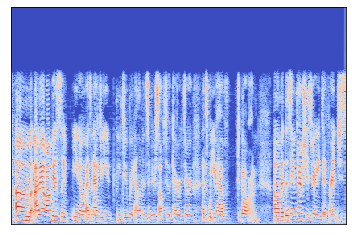

In [65]:
prev_pair = None
count = 0
for pair in image_combinations:
    content_id, style_id = pair.keys()
    userpair = f'{content_id}x{style_id}'
    if prev_pair is None:
        prev_pair = content_id
    elif content_id != prev_pair :
        prev_pair = content_id
        count = 0
    else:
        count += 1
        
    if count >= 9:
        continue
    print(userpair)
    print(pair[content_id]['fullpath'])
    print(pair[style_id]['fullpath'])
    try:
        audio_style_transfer(pair[content_id]['fullpath'],pair[style_id]['fullpath'], content_id, style_id)
    except:
        print(f'Skipped:', userpair)

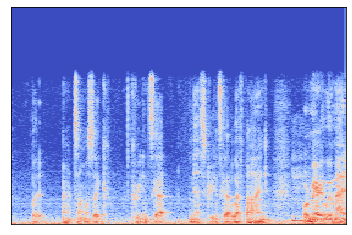

In [66]:
y, fs = librosa.load(os.path.join('./../', pair[style_id]['fullpath']))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y))))


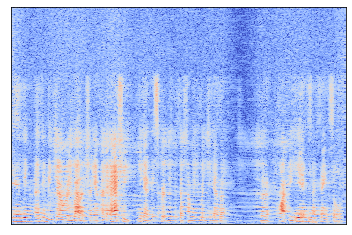

In [59]:
import librosa.display
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(spect))))